# bugfixtime
Predicting how many days it would take to fix a bug, given the Jira information when the bug is filed.

## Motivation
Bugs and software develeopment are inseparable. Also, having bugs in software products implies that at least some man-hour need to be assigned to address them. According to [a study in 2002 by America's National Institute of Standards and Technology (NIST)](http://www.abeacha.com/NIST_press_release_bugs_cost.htm), software bugs cost the U.S. economy an estimated **$59.5 billion** annually, or about 0.6 percent of the gross domestic product. It is almost impossible to expect no bug at all, hence, the second best alternative appears to be knowing how much work is needed to fix them so resources can be maanged efficiently.  
This project attempts to chip away at that problem by trying to predict how many days it would take to fix a bug, given their metadata when they are filed in Jira.

## Problem Statement
The motivation above helps to frame the problem statement into the following,  
*Given the metadata of the bug filed on Jira, predict how many days it would take to close/fix it.*

## Data
The data used in this study is obtained from the research article titled [From Reports to Bug-Fix Commits: A 10 Years Dataset of Bug-Fixing Activity from 55 Apache's Open Source Projects](https://dl.acm.org/doi/10.1145/3345629.3345639) by Vieira, Da Silva, Rocha, and Gomes in 2019. The data is housed [here](https://figshare.com/articles/Replication_Package_-_PROMISE_19/8852084).  
Contained within is a dataset composed of more than 70,000 bug-fix reports from 10 years of bug-fixing activity of 55 projects from the Apache Software Foundation along with their Jira data and status.

## Data Processing
Running `mining-script.py` as specified by the README file in the research article generates 3 CSV files for each of the 55 Apache Software project. The data used in here is from the `<projectname>-full-bug-fix-dataset` file from each project.

### Importing required packages

In [1]:
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor 
from sklearn import preprocessing
import time

### Reading the file with project names
The CSV files generated by `mining-script.py` come in the format `<projectname>-jira-bug-fix-dataset`. Hence, the list of project names is needed to read the CSV files with different project name as prefixes. This list of project name can be found in the file `projects.csv`. However, the project names in the file `projects.csv` does not match the file names exactly and some names have to be added manually.

In [5]:
# read projects.csv
projects = pd.read_csv("data/projects.csv", delimiter=";")

# format the pandas series into list
projectsnames = list(projects["Name"].sort_values())

# missing names
missingnames = ["mng",
                "mrm",
                "dirkrb",
                "dirmina",
                "fc",
                "flink",
                "oozie",
                "hadoop",
                "hbase",
                "hdfs",
                "mapreduce",
                "tap5",
                "ww",
                "yarn"]

# add missing project names
projectsnames = projectsnames + missingnames

The list above is used to create CSV paths for each project's data. Reading the CSV from paths in the list then gives the complete dataset.

In [9]:
# create a list of CSV paths for the for loop below
csvpaths = []
stopwords = ["commons", "core", "mina"]
for name in projectsnames:
    name = name.lower()
    namesplit = name.split(" ")
    namesplit  = [word for word in namesplit if word not in stopwords]
    name = "".join(namesplit)
    path = "./data/" + name + "-jira-bug-fix-dataset.csv"
    csvpaths.append(path)

# for loop to read CSV, append to a dataframe and count the number of files read
filesread = 0
bugsdf = pd.DataFrame()
for path in csvpaths:
    try:
        somecsv = pd.read_csv(path, delimiter=";")
        filesread += 1
        bugsdf = bugsdf.append(somecsv, ignore_index=True)
    except FileNotFoundError:
        continue

print("files read: %i (expect 56)" % filesread)

files read: 56 (expect 56)


## Data cleaning
This section involves examining key aspects of the data such as column names and types, reformatting and cleaning them as necessary.

### Column names and type
Looking at the column names and their datatype can give a rough idea of what can be used as features for the prediction models. The details about what the columns mean can be found in the PDF accompanying the dataset.

In [10]:
# printing the column names and their data types
print(bugsdf.dtypes)

Project                    object
Owner                      object
Manager                    object
Category                   object
Key                        object
Priority                   object
Status                     object
Reporter                   object
Assignee                   object
Components                 object
SummaryTopWords            object
DescriptionTopWords        object
CommentsTopWords           object
CreationDate               object
ResolutionDate             object
LastUpdateDate            float64
AffectsVersions            object
FixVersions                object
NoComments                  int64
FirstCommentDate           object
LastCommentDate            object
NoWatchers                  int64
NoAttachments               int64
FirstAttachmentDate        object
LastAttachmentDate         object
NoAttachedPatches           int64
FirstAttachedPatchDate     object
LastAttachedPatchDate      object
InwardIssueLinks           object
OutwardIssueLi

Both `CreationDate` and `ResolutionDate` are objects while they should be datetime. Casting them as datetime data type.

In [12]:
bugsdf["CreationDate"] = pd.to_datetime(bugsdf["CreationDate"])
bugsdf["ResolutionDate"] = pd.to_datetime(bugsdf["ResolutionDate"])
print(bugsdf.loc[:,["CreationDate", "ResolutionDate"]].dtypes)

CreationDate      datetime64[ns, UTC]
ResolutionDate    datetime64[ns, UTC]
dtype: object


### Missing values
There are missing values in this dataset. This section examines which column contains missing values, and how many.

In [13]:
nantable = bugsdf.isna().sum()
nantable = pd.DataFrame(nantable[nantable > 0], columns = ["Missing value count"])
nantable.index.name = 'Column name'
nantable

,Missing value count
Column name,
Priority,1
Reporter,22
Assignee,8506
Components,30185
SummaryTopWords,744
DescriptionTopWords,4685
CommentsTopWords,3034
LastUpdateDate,80612
AffectsVersions,33415


Among the columns that contain NANs, the columns that will be used as features are
- Priority
- Reporter
- Components
- SummaryTopWords
- DescriptionTopWords

The missing values under these columns will have to be imputed or removed.

**"Priority" column**  
There is only a single row with missing priority value. This row will be dropped.

In [14]:
#dropping the priority row with NAN value
print("bugsdf shape before dropping NAN under 'Priority' column: %s,%s" % bugsdf.shape)
bugsdf = bugsdf[~bugsdf["Priority"].isna()]
print("bugsdf shape after dropping NAN under 'Priority' column: %s,%s" % bugsdf.shape)
# 1 row has been dropped

bugsdf shape before dropping NAN under 'Priority' column: 80612,30
bugsdf shape after dropping NAN under 'Priority' column: 80611,30


**"Reporter" column**  
The 22 rows with missing value under "Reporter" will be dropped as well.

In [16]:
#dropping the priority row with NAN value
print("bugsdf shape before dropping NAN under 'Reporter' column: %s,%s" % bugsdf.shape)
bugsdf = bugsdf[~bugsdf["Reporter"].isna()]
print("bugsdf shape after dropping NAN under 'Reporter' column: %s,%s" % bugsdf.shape)
# 1 row has been dropped

bugsdf shape before dropping NAN under 'Reporter' column: 80589,30
bugsdf shape after dropping NAN under 'Reporter' column: 80589,30


The NANs in other columns will be addressed in the feature engineering section.

## Feature Engineering
Some features have to be created from existing feature(s). Here, the target variable `DaysToFix` is crated as well.

### Creating the target variable - DaysToFix
The time difference between `CreationDate` and `ResolutionDate` is the amount of time it took to resolve or close the bugs. 
Calculating the time to resolution. The column will be named `DaysToFix`.

In [17]:
bugsdf["DaysToFix"] = bugsdf["ResolutionDate"] - bugsdf["CreationDate"]
# only taking the days, ignoring the hours.
bugsdf["DaysToFix"] = bugsdf["DaysToFix"].apply(lambda x: x.days)

### Feature engineering - components
The feature "Components" may have a significant impact on the number of days taken to fix the bugs. However, there are a lot of NaNs in the column. As such, a new feature called `HasComponents` has to be created. It would be a boolean value that expresses whether or not the Jira bug has components data.

In [18]:
bugsdf["HasComponents"] = bugsdf.apply(lambda x: False if pd.isnull(x["Components"]) else True, axis=1)

Plotting `DaysToFix` by `HasComponents`

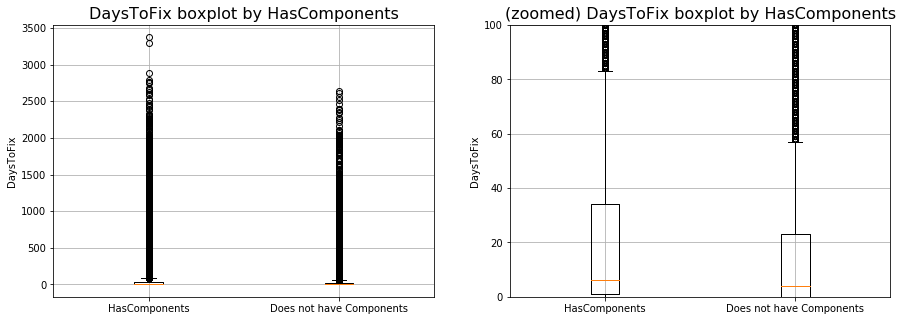

In [68]:
withcomponents = bugsdf[bugsdf["HasComponents"] == True]["DaysToFix"].values
withoutcomponents = bugsdf[bugsdf["HasComponents"] == False]["DaysToFix"].values

fig, (ax1, ax2) =  plt.subplots(1,2, figsize = (15,5))
ax1.boxplot(np.array([withcomponents,withoutcomponents]))
ax1.set_title("DaysToFix boxplot by HasComponents", fontsize=16)
ax1.set_xticklabels(['HasComponents', 'Does not have Components'])
ax1.set_ylabel("DaysToFix")
ax1.grid()

ax2.boxplot(np.array([withcomponents,withoutcomponents]))
ax2.set_ylim(0,100)
ax2.set_title("(zoomed) DaysToFix boxplot by HasComponents", fontsize=16)
ax2.set_xticklabels(['HasComponents', 'Does not have Components'])
ax2.set_ylabel("DaysToFix")
ax2.grid();

### Feature engineering - bug reporter and assignee
Another feature that might affect `DaysToFix` would be if the bug reporter and assignee are the same person. That is, the reporter assigns the bug to him/herself. Another possibility would be that the bug is not assigned to anyone. The column will be called "AssignedTo" and it will have 3 possible values: 1. 'self' 2. 'other' 3. 'noone'.

In [69]:
bugsdf["AssignedTo"] = bugsdf.apply(lambda x: 'self' if x["Reporter"] == x["Assignee"]  else ('noone' if pd.isnull(x["Assignee"]) else 'other'), axis=1)

# verifying the column values
bugsdf.loc[15:25,["Reporter", "Assignee", "AssignedTo"]]

,Reporter,Assignee,AssignedTo
15,ittayd,lacton,other
16,jmhodges,vic,other
17,boisvert,NaN,noone
18,crnixon,NaN,noone
19,tuomask,NaN,noone
20,djspiewak,djspiewak,self
21,rsutphin,djspiewak,other
22,ittayd,boisvert,other
23,hmalphettes,boisvert,other
24,alexismidon,NaN,noone


### Feature engineering - summary and description top words
There are 3 colums that contain information about term frequency in the summary, description, and comment section. They are called `SummaryTopWords`, `DescriptionTopWords`, and `CommentsTopWords` respectively. Since `CommentsTopWords` could be populated after the bugs were filed, this field will not be used as feature.  
The idea is to use the information available at the time the bugs were filed to predict the time it would take to fix or close the bugs. As such, only the data in `SummaryTopWords` and `DescriptionTopWords` will be used. Looking at the data in the TopWords columns,

In [70]:
# examining the columns

bugsdf.loc[:,["SummaryTopWords", "DescriptionTopWords", "CommentsTopWords"]].tail(10)

,SummaryTopWords,DescriptionTopWords,CommentsTopWords
80602,log:1 aggregation:1 changes:1 handle:1 support...,java:10 apache:8 yarn:8 server:4 permissions:3...,color:372 green:144 yarn:39 patch:38 passed:26...
80603,ats:1 leaks:1 native:1 memory:1,files:3 even:3 yarn:2 ats:2 shows:2 though:2 u...,color:420 green:156 patch:46 yarn:40 passed:29...
80604,error:1 package:1,yarn:30 error:22 server:18 java:13 apache:12 b...,color:186 green:76 yarn:29 patch:20 server:15 ...
80605,contact:1 option:1,logs:3 yarn:2 contact:2 even:1 though:1 config...,color:372 green:162 patch:33 yarn:31 passed:28...
80606,yarn:1 service:1 upgrade:1 instance:1 state:1 ...,instance:4 state:3 changes:3 stable:2 currentl...,color:744 green:320 yarn:126 patch:69 passed:5...
80607,yarn:1 resource:1 manager:1 running:1 leak:1 c...,object:4 memory:3 configuration:2 gc:2 apache:...,color:816 green:318 yarn:105 patch:81 passed:5...
80608,nm:1 service:1 updated:1 status:1 containers:1,container:9 monitoring:4 process:4 nm:3 runnin...,color:1086 green:421 yarn:139 patch:106 passed...
80609,upgrade:2 service:1 default:1 readiness:1 chec...,yarn:3 ip:3 address:2 nm:2 container:2 launche...,color:372 green:149 yarn:70 patch:38 passed:25...
80610,log:1 service:1 redirect:1 url:1 need:1 suppor...,add:1 yarn:1 log:1 service:1 end:1 point:1,color:82 green:29 yarn:13 patch:8 trunk:6 apac...
80611,fix:1 itemization:1 yarn:1 service:1 document:1,service:4 name:2 note:2 needs:2 unique:2 acros...,color:18 yarn:12 apache:6 red:5 https:4 blue:4...


The intended text analysis approach to be used is term frequency-inverse document frequency or TF-IDF. As such, the word-frequency pairs under the TopWords columns will have to be reformatted back into space separated strings. The content of `SummaryTopWords` and `DescriptionTopWords` will be combined.  
Writing function to generate the word bag.

In [71]:
def get_wordbag(top_words):
    '''
    Function to produce a word bag, given word-frequency pair
    args:
    top_words - a string-separated word-frequency pairs in the format <word>:<freq>
    return:
    space-separated string of words in the word bag, repeated according to their frequency
    '''
    porter = PorterStemmer()
    if pd.isnull(top_words):
        return ''
    wordlist = top_words.split(" ")
    wordlist = [pair.split(":") for pair in wordlist]
    wordbag = ""
    for word, freq in wordlist:
        for i in range(0,int(freq)):
            word = porter.stem(word)
            wordbag = wordbag + word + " "
    return wordbag[:-1]

In [72]:
# using the function above to generate space separated strings from both TopWords columns to get a word bag
t1 = time.time()
bugsdf["WordBag"] = bugsdf.apply(lambda x: get_wordbag(x["SummaryTopWords"]) + " " + get_wordbag(x["DescriptionTopWords"]), axis=1)
t2 = time.time()

print("time taken to generate word bag: %0.2f" % (t2-t1))
bugsdf["WordBag"][0:10]

time taken to generate word bag: 183.41


0      download link broken download link valid instal
1    misss consol ant ant ant ant derbi derbi task ...
2    http redirect lose authent inform authent auth...
3    gener pay attent h h h file file file project ...
4    unrecogn option silent silent silent option op...
5    convert maven project fail intern error call s...
6    test framework pass configur system properti r...
7    classifi handl download snapshot artifact arti...
8    similar compress jar jar attribut default comp...
9    automat instal instal depend version version u...
Name: WordBag, dtype: object

## Exploratory data analysis 
Performing exploratory data analysis on the dataset and further feature engineering